In [3]:
from __future__ import division, print_function, absolute_import
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.font_manager as fm # to create font
import numpy as np
import cv2
import os
import sys
from math import *
from PIL import Image,ImageFont
from timeit import time

# set config to initialize cudnn
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from stereo_reconstruction import structure
from stereo_reconstruction import processor
from stereo_reconstruction.features import match_images

from yolo3_deepsort.yolo import YOLO
from yolo3_deepsort.deep_sort.detection import Detection
from yolo3_deepsort.deep_sort.tracker import Tracker
from yolo3_deepsort.deep_sort.track import MotionState,SecurityState
from yolo3_deepsort.tools import generate_detections as gdet
from yolo3_deepsort.deep_sort.detection import Detection as ddet
import yolo3_deepsort.tools.box_filter as box_filter

import json
from utils.data_utils import load_frametime,load_fuseddata,Camera
from utils.coord_utils import linear_interpolation,CSI
from utils.coord_utils import computeVelocity,computeAcceleration
from utils.plot_utils import draw_one_box as draw_box
from utils.plot_utils import Canvas

# Initialize

In [4]:
# create yolov3 detector
score_thre = 0.4
iou_thre = 0.3
yolo = YOLO(model_path = 'yolo3_deepsort/model_data/yolo_ori.h5',
            classes_path = 'yolo3_deepsort/model_data/coco_classes.txt',
            weights_only = True,
            score = score_thre,
            iou = iou_thre) # coco version
# yolo = YOLO(model_path = 'yolo3_deepsort/model_data/trained_weights_coco.h5',
#             classes_path = 'yolo3_deepsort/model_data/classes_name.txt',
#             weights_only = True,
#             score = score_thre,
#             iou = iou_thre) # our version

# create feature encoder
model_filename = 'yolo3_deepsort/model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)

# create tracker
max_distance = 0.3
lambda0 = 0.5# SORT(1),DeepSORT(0)
nn_budget = None
tracker = Tracker(metric_mode="combine",max_cosine_distance=max_distance,
                      lambda0 = lambda0,nn_budget=nn_budget)

thickness = 150#边缘忽略区
COI = ['person','bicycle','car','motorcycle','bus','train','truck']#感兴趣的类别

scale = 80
hh = 9*scale#窗口高度
ww2 = 16*scale#图像区宽度
ww1 = 350 #信息区宽度
fontsize = 12
font = ImageFont.truetype(fm.findfont(fm.FontProperties(family='DejaVu Sans')),fontsize)
# 初始化
canvas = Canvas(h=hh,w1=ww1,w2=ww2,font=font,line_space=15)#创建画布

yolo3_deepsort/model_data/yolo_ori.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






# Camera Infomation

In [5]:
# read camera parameters

work_path = "/media/yxhuang/database/binocular_video/"
intrinsic_path = work_path + r'stereo_intrinsic.yml'
extrinsic_path = work_path + r'stereo_extrinsic.yml'
# intrinsic_path = r'G:\binocular_video\stereo_intrinsic.yml'
# extrinsic_path = r'G:\binocular_video\stereo_extrinsic.yml'
extrinsic_paras = cv2.FileStorage(extrinsic_path, cv2.FILE_STORAGE_READ)
P1 = extrinsic_paras.getNode('P1').mat()
P2 = extrinsic_paras.getNode('P2').mat()


In [6]:
# motion infomation
frame_time = load_frametime("/media/yxhuang/database/binocular_video/20191022_022500_time.txt")
fused_data = load_fuseddata("/media/yxhuang/database/binocular_video/fused_pose_planePoint_1022_022500.txt")

X = []; Y = []; Z = []; yaw = []
ts = []; Rs = []
# 插值运算
for time in frame_time:
    inter_data = linear_interpolation(fused_data,time)

    tx = inter_data["x"];ty = inter_data["y"];tz = inter_data["z"];
    X.append(tx); Y.append(ty); Z.append(tz)
    t = np.array([tx,ty,tz]).reshape(3,1)
    ts.append(t);

    r = inter_data["roll"];p = inter_data["pitch"];y = inter_data["yaw"]-3*pi/2;
    yaw.append(y)
    
    Rr = np.array([[1, 0,       0],
                   [0, cos(r), -sin(r)],
                   [0, sin(r),  cos(r)]]).reshape(3,3)
    Rp = np.array([[cos(p), 0, sin(p)],
                   [0,      1, 0     ],
                   [-sin(p),0, cos(p)]]).reshape(3,3)
    Ry = np.array([[cos(y), -sin(y), 0],
                   [sin(y),  cos(y), 0],
                   [0,       0,      1]]).reshape(3,3)

    R = Rr@Rp@Ry
    Rs.append(R)
    
X = np.array(X); Y = np.array(Y); Z = np.array(Z);
T = np.array(frame_time)/1000
yaw = np.array(yaw)*180/pi
vx,vy,vz,v = computeVelocity(X,Y,Z,T)
ax,ay,az,a = computeAcceleration(X,Y,Z,T)
cur = CSI(X,Y)

93105269.61882856


Text(0, 0.5, 'Acceleration m/s2')

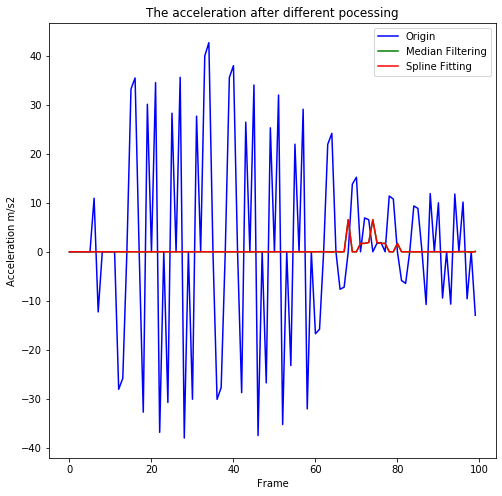

In [14]:
from scipy.interpolate import splev, splrep
import scipy.signal as signal

var = a
v_md = signal.medfilt(volume=var, kernel_size=11)

ran = [0,100]
var_md = v_md

spl = splrep(range(len(var_md)), var_md,s=5)
var_spl = splev(range(len(var_md)), spl)

print(np.sum((var-var_spl)**2))
plt.figure(figsize=(8,8))
plt.plot(var[ran[0]:ran[1]],"b")
plt.plot(var_md[ran[0]:ran[1]],"g")
plt.plot(var_spl[ran[0]:ran[1]],"r")

l = ['Origin',"Median Filtering","Spline Fitting"]
plt.legend(l)
plt.title('The acceleration after different pocessing')
plt.xlabel("Frame")
plt.ylabel("Acceleration m/s2")

# Tracking

In [ ]:
# set video config

# video_path = r"G:\binocular_video\20191022_022500_video.h265"
video_path = "/media/yxhuang/database/binocular_video/20191022_022500_video.h265"
cap = cv2.VideoCapture(video_path)
w = int(cap.get(3))
h = int(cap.get(4))
fps = cap.get(5)

write_flag = True
if write_flag:
    out = cv2.VideoWriter('result/track_with_info.avi',cv2.VideoWriter_fourcc(*'XVID'), 
                          fps, ((ww1+ww2),hh))
fontsize = 25
frame_num = 0 #当前帧数

In [ ]:
while cap.isOpened():
    # read video
    ret,frame = cap.read()
    frame_num += 1
    if ret != True:
        break# it's really really really important!!!
        
    frame_left = frame[:,:w//2,:]
    frame_right = frame[:,w//2:,:]
    img_left_pil = Image.fromarray(frame_left.copy()[...,::-1])
    
    # detection
    boxes,classes,scores = yolo.detect_image(img_left_pil)
    
    # filter boxes
    boxes, classes, scores = box_filter.remove_edge(boxes,classes,scores,thickness,(w//2,h))
    boxes, classes, scores = box_filter.select_classes(boxes,classes,scores,COI)
    boxes, classes, scores = box_filter.non_max_suppression(boxes,classes,scores,iou_thre)
    
    pts3D = []
    distance = []
    boxes = np.array(boxes)# easier to compute
    for i,box in enumerate(boxes):
        ret,search_patch,box_matched = match_images(frame_left,frame_right,box,offset=(-400,-40,0,40),
                                       method = cv2.TM_CCOEFF_NORMED)# match two image
        box_matched = np.array(box_matched)
        pt2D_l = np.ones((3,1),dtype='float')#left center of box
        pt2D_r = np.ones((3,1),dtype='float')#righr center of box
        pt2D_l[:2,0] = box[:2] + box[2:]/2.
        pt2D_r[:2,0] = (box_matched[:2] + box_matched[2:])/2.

        # triangulation
        pt3D = structure.linear_triangulation(pt2D_l,pt2D_r,P1,P2)#相对坐标(分米)
        distance.append(np.sqrt(np.sum(pt3D[:3]**2))/10) #距离
        pt3D = np.array([pt3D[2,0],-pt3D[0,0],-pt3D[1,0]]).reshape(3,1)/10 #坐标系变换
        pt3D = Rs[frame_num-1] @ pt3D + ts[frame_num-1]#世界坐标系坐标
        pts3D.append(pt3D)
        
    # encoder features
    features = encoder(frame_left,boxes)
    detections = []
    for i,b in enumerate(boxes):
        info_dict = {"feature":features[i],"frame":frame_num,
                     "time":T[frame_num-1],"distance":distance[i],
                     "XYZ":pts3D[i]}
        det = Detection(b,scores[i],classes[i],info_dict=info_dict)
        detections.append(det)
    
    # call the tracker
    tracker.predict()
    tracker.update(detections)
    
    # ==============可视化===============
    # 绘制边框
    img_left_draw = img_left_pil.copy()
    
    tracks = []
    for i,track in enumerate(tracker.tracks):
        if not track.is_confirmed() or track.time_since_update > 1:
            continue
        
         # for coco version
        if track.track_id in [3,5,146,226,244,250,257,362]:
            continue
        tracks.append(track)
        
        bbox = track.to_tlbr()
        # property of the object
        object_id = track.track_id
        object_class = track.object_class
        color = yolo.colors[yolo.class_names.index(object_class)]
        # draw boxes
        img_left_draw = draw_box(img_left_draw,bbox,object_id,object_class,color,
                                 fontsize,track.security_state)
    
    # 相机的信息
    camera = Camera(XYZ=[X[frame_num-1],Y[frame_num-1],Z[frame_num-1]],
                    direction = yaw[frame_num-1],velocity=v[frame_num-1],
                    acceleration = a[frame_num-1],curve=cur[frame_num-1],
                    motion_state = MotionState.Pending)
    canvas.update(img_left_draw,frame_num,T[frame_num-1],camera,tracks=tracks)#显示信息
    cv2.imshow("demo",np.array(canvas.canvas)[...,::-1])
    
    if write_flag:
        out.write(np.array(canvas.canvas)[...,::-1])# save result
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
if write_flag:
    out.release()
cap.release()
cv2.destroyAllWindows()